<a href="https://colab.research.google.com/github/chahitshah/braintumordetection/blob/main/braintummorcombine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow matplotlib

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input, Average
from keras.applications import ResNet50
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(data_dir):
    images = []
    labels = []

    for label in ['no_tumor', 'tumor']:
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = load_img(img_path, target_size=(224, 224))
            image = img_to_array(image) / 255.0  # Normalize to [0, 1]
            images.append(image)
            labels.append(1 if label == 'tumor' else 0)

    return np.array(images), np.array(labels)

# Load your data (update the path accordingly)
X, y = load_data('/content/drive/MyDrive/1/1')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)


In [ ]:
def create_sequential_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    return model

def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model


In [ ]:
def create_combined_model():
    input_layer = Input(shape=(224, 224, 3))

    seq_model = create_sequential_model()(input_layer)
    resnet_model = create_resnet_model()(input_layer)

    combined_output = Average()([seq_model, resnet_model])
    final_model = Model(inputs=input_layer, outputs=combined_output)
    return final_model

In [ ]:
model = create_combined_model()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=50)
                    #callbacks=[early_stopping])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.6683 - loss: 0.5599 - val_accuracy: 0.4976 - val_loss: 0.7476
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 414ms/step - accuracy: 0.9001 - loss: 0.3154 - val_accuracy: 0.4976 - val_loss: 0.9669
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 484ms/step - accuracy: 0.9235 - loss: 0.2576 - val_accuracy: 0.4976 - val_loss: 0.9540
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 413ms/step - accuracy: 0.9134 - loss: 0.2233 - val_accuracy: 0.7073 - val_loss: 0.5612
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 480ms/step - accuracy: 0.9189 - loss: 0.2283 - val_accuracy: 0.6829 - val_loss: 0.5128
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 477ms/step - accuracy: 0.8369 - loss: 0.3116 - val_accuracy: 0.4976 - val_loss: 0.6675
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 480ms/step - accuracy: 0.9288 - loss: 0.2068 - val_accuracy: 0.6585 - val_loss: 0.5099
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 472ms/step - accuracy: 0.8584 - loss: 0.2929 - val_accuracy: 0.8878 

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.8087 - loss: 0.3952
Test Accuracy: 81.95%


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("-"*30)
print("Accuracy:", accuracy)
print("Precision:", precision)


data = {'Metric': ['Accuracy', 'Precision'],
        'Value': [accuracy, precision]}

import pandas as pd
df = pd.DataFrame(data)

print(df)

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 625ms/step
------------------------------
Accuracy: 0.8195121951219512
Precision: 0.746268656716418
      Metric     Value
0   Accuracy  0.819512
1  Precision  0.746269


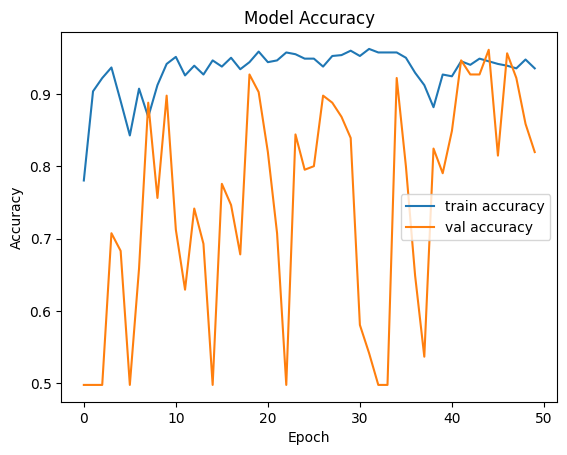

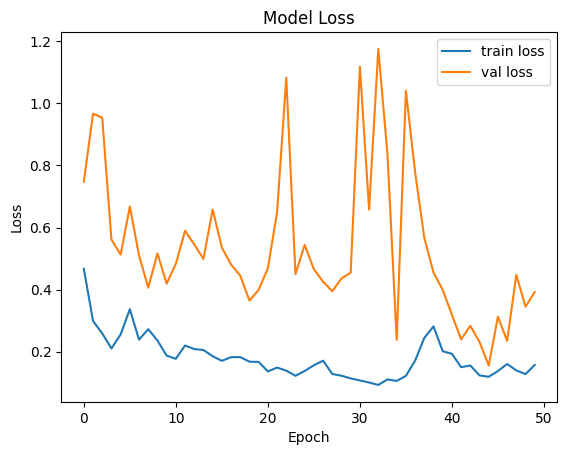

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
